<a href="https://colab.research.google.com/github/dipayandas97/Spiking-Neural-Network/blob/master/(3)_multi_layer_SNN_%26_GA_%26_Rate_Coded_input.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from google.colab import drive
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split

drive.mount('/content/drive/')
import sys
sys.path.append('/content/drive/My Drive/Final_year_project/NLOS_data/SNN_GA/')

from neuron_models import LIF
from GA import GA
from SNN_Model import SNN_Model

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


#Data preparation

In [0]:
class rate_encode:
    def __init__(self, time_window, input_range, output_range):
        self.time_window = time_window
        self.min_input = input_range[0]
        self.max_input = input_range[1]
        self.min_output = output_range[0]
        self.max_output = output_range[1]

    def encode(self, vector): #1D vector
        spike_train = []
        for v in vector:
            freq = (((v-self.min_input)/(self.max_input-self.min_input)) * (self.max_output-self.min_output)) + self.min_output 
            t = (1 / freq) * 1000 #ms                    
            
            spikes = np.zeros(self.time_window)
            k=0
            while k<self.time_window and k+int(t)<self.time_window:
                k += int(t)
                spikes[k] = 1
            spike_train.append(spikes)
        spike_train = np.asarray(spike_train)
        return spike_train   

In [0]:
#functions to transform scaler data to spike time points and vice versa
#[a,b] : Min,Max value of temporal encoding
#[M:m] : Max,Min value that variable f can take

#since input range[0,22] so output range will be [0,66]. additional 33 settling time can be allotted in the beginning
#So output format: [0:33]=relaxation, true value in [33:99]

def scaler_to_temporal_value(f):
    #return (((b-a)/(M-m))*f) + (((a*M)-(b*m))/(M-m))
    return 33+(3*f) 
    
def temporal_to_scaler_value(y):
    #return (y - (((a*M)-(b*m))/(M-m))) / ((b-a)/(M-m))
    return (y-33)/3

In [5]:
#Data--------------------------------------------------------------------------------------------------------------------------------------------------
#signal #Input signal : shape(batchsize, features, timesteps)
f = open('/content/drive/My Drive/Final_year_project/NLOS_data/SNN_GA/total_data.pkl', 'rb')
X, Y = pickle.load(f)
f.close()

#Rate Encode X
encoder = rate_encode(100, (-110,-22), (10, 200))
signal_X = []
for x in X:
    signal_X.append(encoder.encode(x))
signal_X = np.asarray(signal_X)

#Time Encode Y
signal_Y = []
min_y, max_y = np.min(Y), np.max(Y)
for y in Y:
    t = scaler_to_temporal_value(f=y)
    spikes_y = np.zeros((2,100))
    spikes_y[0][t[0]], spikes_y[1][t[1]] = 1,1
    signal_Y.append(spikes_y)
signal_Y = np.asarray(signal_Y)

X_train, X_test, y_train, y_test = train_test_split(signal_X, signal_Y, test_size=0.2, shuffle=True)
print('Train sizes: ',X_train.shape, y_train.shape)
print('Test sizes: ',X_test.shape, y_test.shape)



Train sizes:  (4080, 4, 100) (4080, 2, 100)
Test sizes:  (1020, 4, 100) (1020, 2, 100)


#Fitness Calculation

##error()

In [0]:
#Spike distance----------------------------------------------------------------------------------------------------------------------------------------

def error(y_true, y_pred):
    if y_true.shape != y_pred.shape:
        raise Exception('Shape of y_true and y_pred is not equal')
    
    true_timestamps, pred_timestamps = np.zeros((y_true.shape[0],))-1, np.zeros((y_pred.shape[0],))-1
    
    for d in range(y_true.shape[0]):
    
        for t in range(y_true.shape[1]):
            if y_true[d][t] == 1:           # |delta(n)| = 1
                true_timestamps[d] = t
                break
        for t in range(y_pred.shape[1]):
            if y_pred[d][t] == 1:           # |V_spike| = 5
                pred_timestamps[d] = t
                break                        
        #if no spikes have been predicted
        if pred_timestamps[d] == -1:
            pred_timestamps[d] = y_true.shape[1]*2

    pred_timestamps[pred_timestamps==-1] = 0
    true_timestamps[true_timestamps==-1] = 0
    e = [(true_timestamps[i]-pred_timestamps[i])**2 for i in range(y_true.shape[0])]
    e = np.sqrt(np.sum(e))
    return e

##mp_fitness()

In [0]:
#Multi-proecssing

def mp_fitness(synapse_vector, output): #fitness of one vectored synapse
    
    #Network instance for this sub-process
    model = SNN_Model(input_dim=input_dim, neurons_per_layer=neurons_per_layer, threshold=threshold, Cm=Cm)  
    initial_synapse_list = model.synapse_list
    
    synapse_id = synapse_vector[-1] 
    synapse_vector = synapse_vector[:-1]
    synapse_matrices_list = ga.vector_to_matrix(vector = synapse_vector, dummy_matrices=initial_synapse_list)

    model.set_synapses(synapse_matrices_list)

    #Error on train_data
    temp_train_score = []      
    for i in range(X_train.shape[0]):     
        model_output = model.predict(X_train[i])[-1]    #Last array represents activations of output layer
        temp_train_score.append( error(y_train[i],model_output) )

    #Error on test data
    temp_test_score = []        
    for i in range(X_test.shape[0]):   
        model_output = model.predict(X_test[i])[-1]    #Last array represents activations of output layer      
        temp_test_score.append( error(y_test[i], model_output) )

    output.put([synapse_id, np.mean(temp_train_score), np.mean(temp_test_score)])

#Main : Optimization

##Evaluating

In [0]:
f = open('/content/drive/My Drive/Final_year_project/NLOS_data/SNN_GA/best_paramater_found.pkl','rb')
vector = pickle.load(f)
f.close()

In [0]:
def random_evaluate(vector, input_dim=4, neurons_per_layer=[6,2], threshold=0.2, Cm=10):

    model = SNN_Model(input_dim=input_dim, neurons_per_layer=neurons_per_layer, threshold=threshold, Cm=Cm)
    dum_mat = model.synapse_list
    model.set_synapses(ga.vector_to_matrix(vector, dum_mat))

    s = np.random.randint(0,1000,1)[0]
    y_pred = model.predict(X_test[s])

    print('Evaluation Error:', error(y_test[s], y_pred[-1]))
    
    plt.figure(dpi=100, figsize=(20,4))
    for l in range(len(y_pred)):
        plt.subplot(2,len(y_pred)+1,l+1)
        plt.title('Layer '+str(l))
        for i in range(y_pred[l].shape[0]):
            plt.plot(y_pred[l][i,:])
    plt.show()

    plt.title('Y_true', fontsize=16)
    for i in range(y_test[s].shape[0]):
        plt.plot(y_test[s][i,:])
    plt.show()    

Evaluation Error: 32.38826948140329


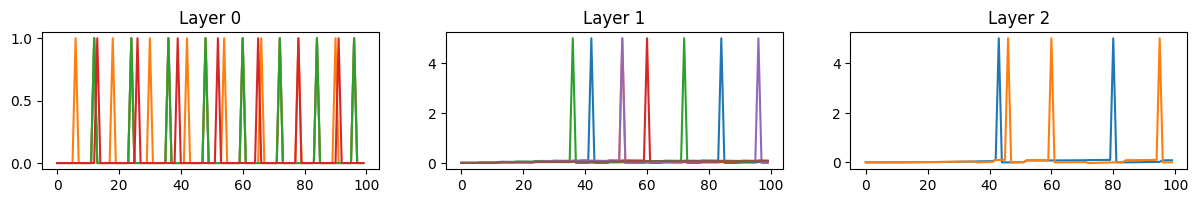

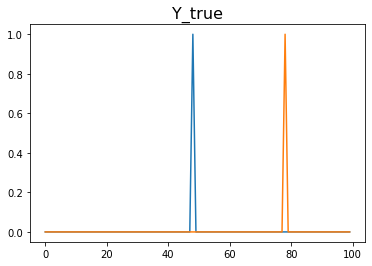

In [128]:
evaluate(vector=parents[0], threshold=0.1, Cm=10)

##Parallel GA

Generation :  1 / 20
Mean Train Error by entire population: 42.95397200529611
Mean Test Error by entire population: 42.83056916385526


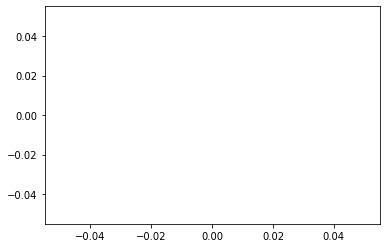

Evaluation Error: 10.770329614269007


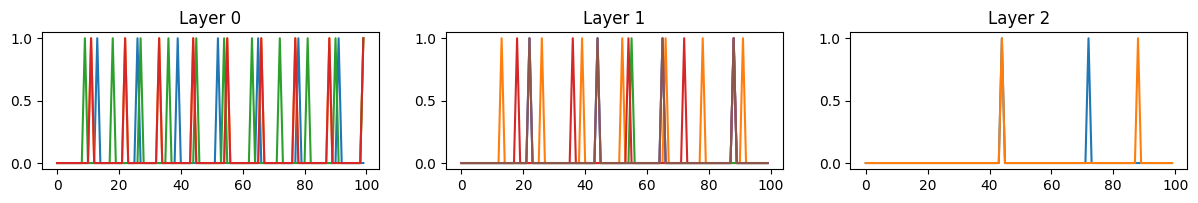

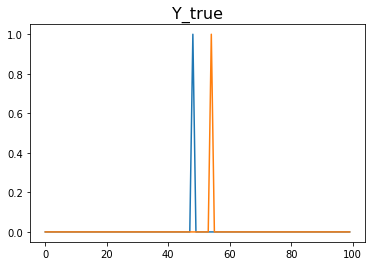

Generation :  2 / 20
Mean Train Error by best parameters found: 23.875564915558304
Mean Test Error by best parameters found: 24.192870237542593

Mean Train Error by entire population: 39.917701659683516
Mean Test Error by entire population: 39.89395895890095


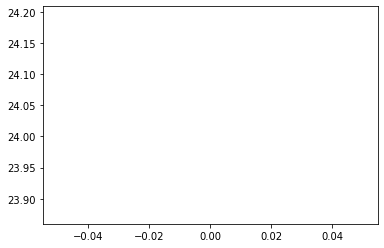

Evaluation Error: 49.47726750741192


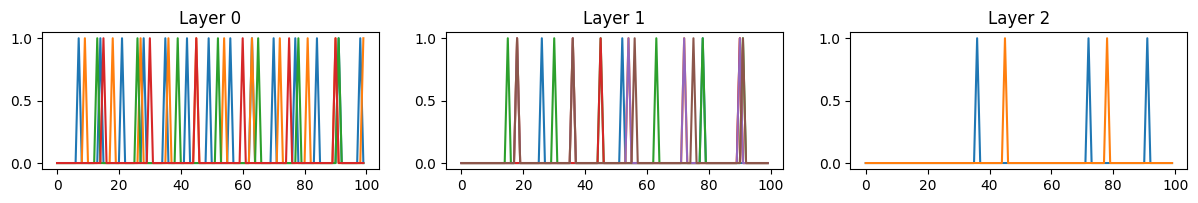

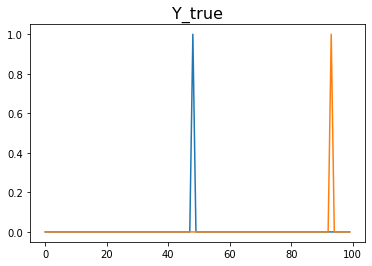

Generation :  3 / 20
Mean Train Error by best parameters found: 22.397469441397245
Mean Test Error by best parameters found: 22.478653308472953

Mean Train Error by entire population: 47.543746072224636
Mean Test Error by entire population: 47.20262524958294


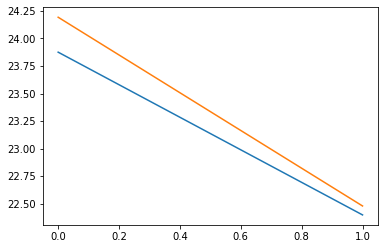

Evaluation Error: 5.830951894845301


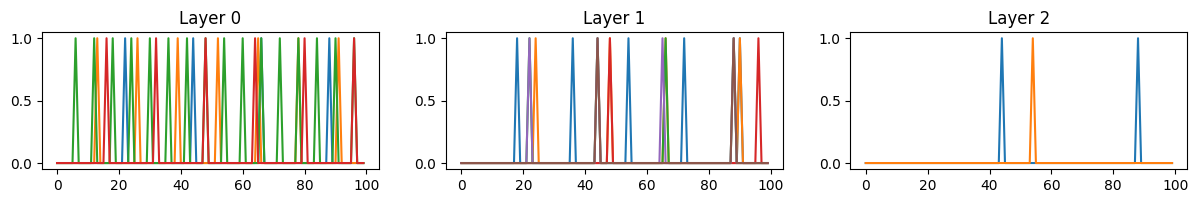

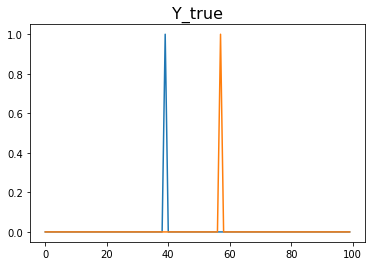

Generation :  4 / 20
Mean Train Error by best parameters found: 22.397469441397245
Mean Test Error by best parameters found: 22.478653308472953

Mean Train Error by entire population: 40.3119625223051
Mean Test Error by entire population: 39.95357092024372


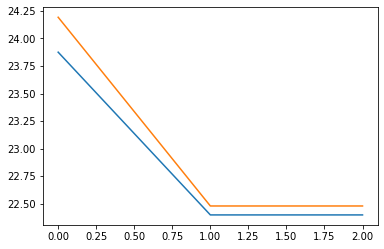

Evaluation Error: 15.811388300841896


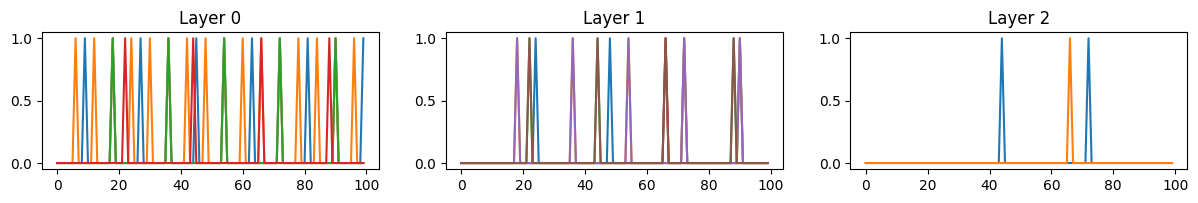

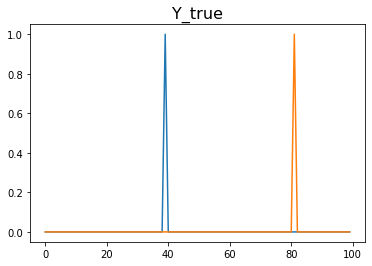

Generation :  5 / 20
Mean Train Error by best parameters found: 22.397469441397245
Mean Test Error by best parameters found: 22.478653308472953

Mean Train Error by entire population: 45.35532990326809
Mean Test Error by entire population: 44.96202021126439


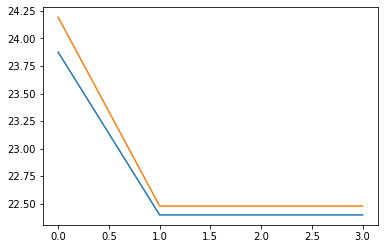

Evaluation Error: 15.0


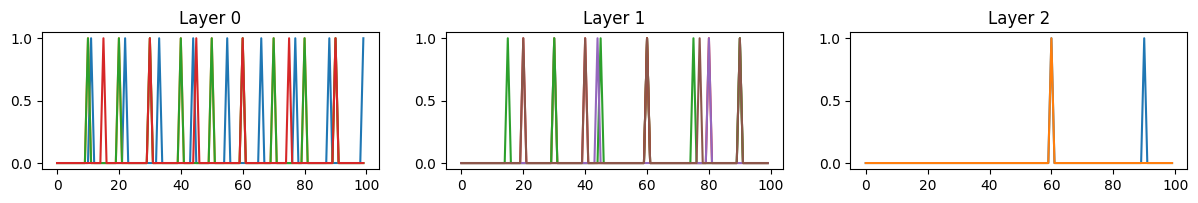

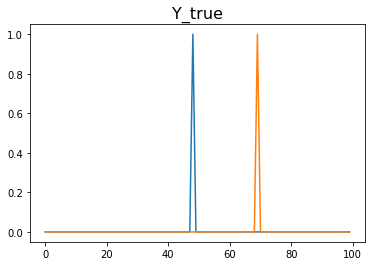

Generation :  6 / 20
Mean Train Error by best parameters found: 19.890097441096906
Mean Test Error by best parameters found: 20.30690296529374

Mean Train Error by entire population: 51.53890105393991
Mean Test Error by entire population: 51.13143271525261


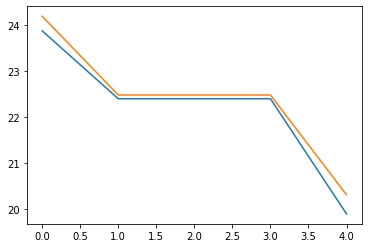

Evaluation Error: 7.0710678118654755


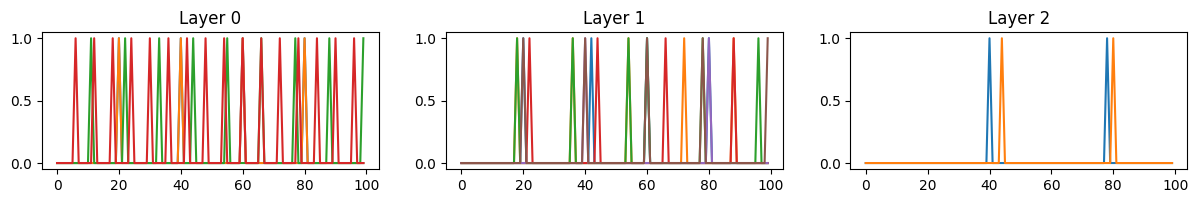

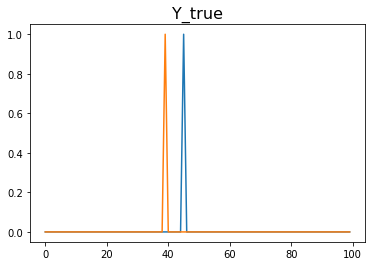

Generation :  7 / 20
Mean Train Error by best parameters found: 19.890097441096906
Mean Test Error by best parameters found: 20.30690296529374

Mean Train Error by entire population: 39.03281929739173
Mean Test Error by entire population: 38.70471444370736


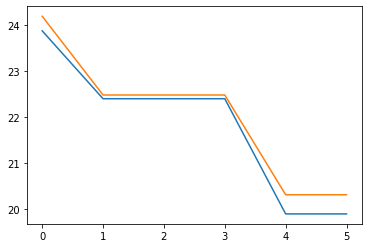

Evaluation Error: 28.231188426986208


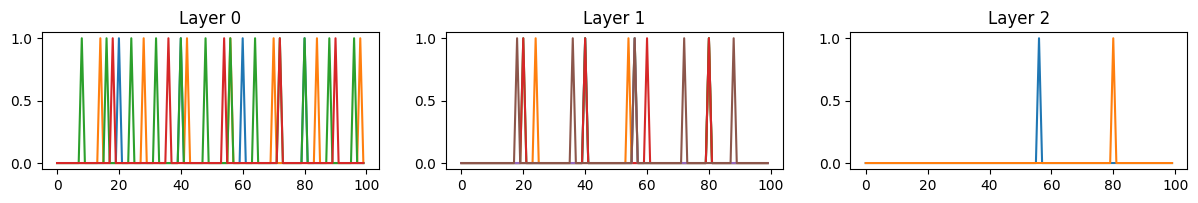

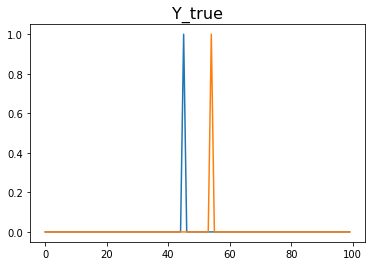

Generation :  8 / 20
Mean Train Error by best parameters found: 19.890097441096906
Mean Test Error by best parameters found: 20.30690296529374

Mean Train Error by entire population: 60.13939631473529
Mean Test Error by entire population: 59.58442508934502


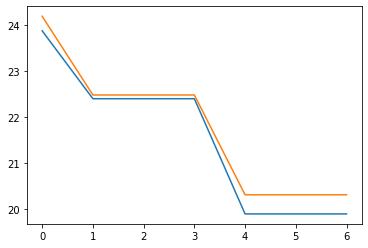

Evaluation Error: 25.612496949731394


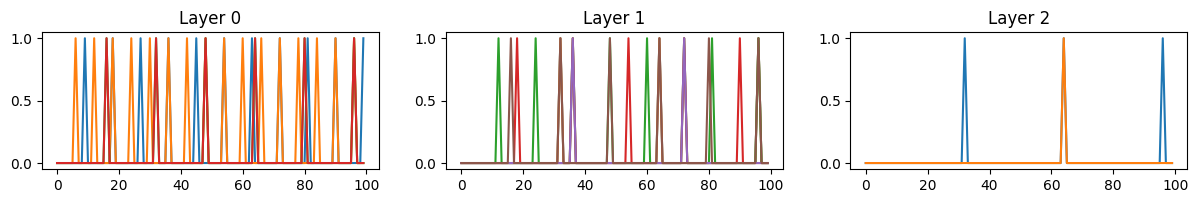

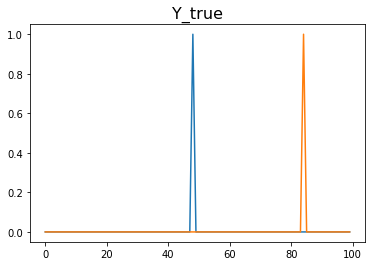

Generation :  9 / 20
Mean Train Error by best parameters found: 19.890097441096906
Mean Test Error by best parameters found: 20.30690296529374

Mean Train Error by entire population: 50.52146018918057
Mean Test Error by entire population: 50.46921075290223


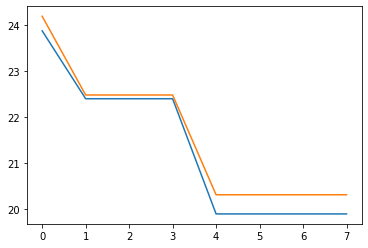

Evaluation Error: 9.433981132056603


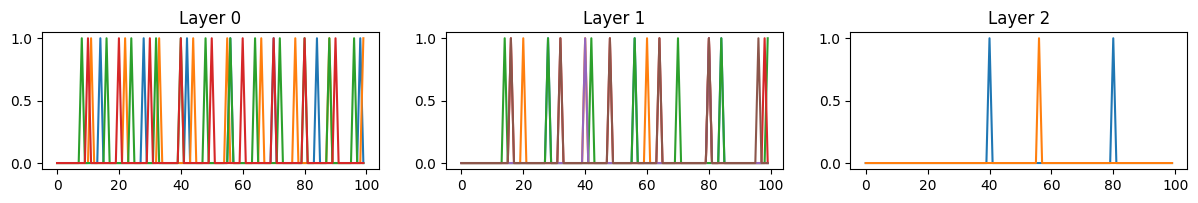

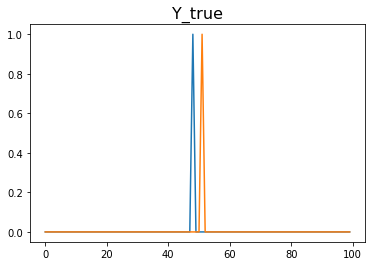

Generation :  10 / 20
Mean Train Error by best parameters found: 19.890097441096906
Mean Test Error by best parameters found: 20.30690296529374

Mean Train Error by entire population: 42.49300677992282
Mean Test Error by entire population: 42.04276775262556


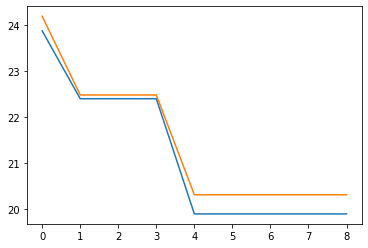

Evaluation Error: 11.0


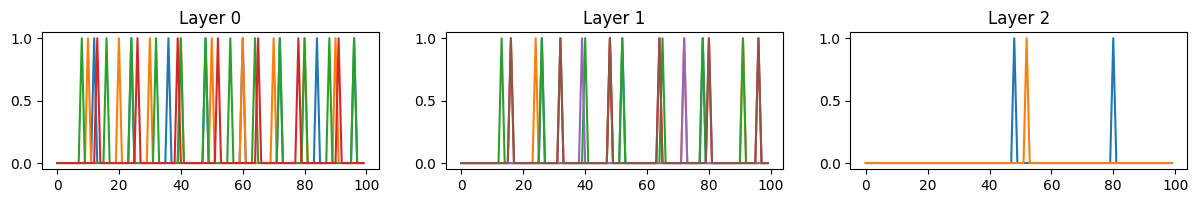

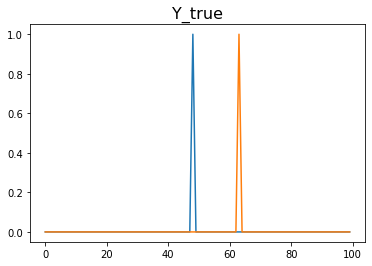

Generation :  11 / 20
Mean Train Error by best parameters found: 19.890097441096906
Mean Test Error by best parameters found: 20.30690296529374

Mean Train Error by entire population: 48.521329766286144
Mean Test Error by entire population: 48.277118655192176


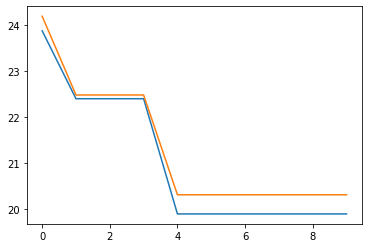

Evaluation Error: 24.73863375370596


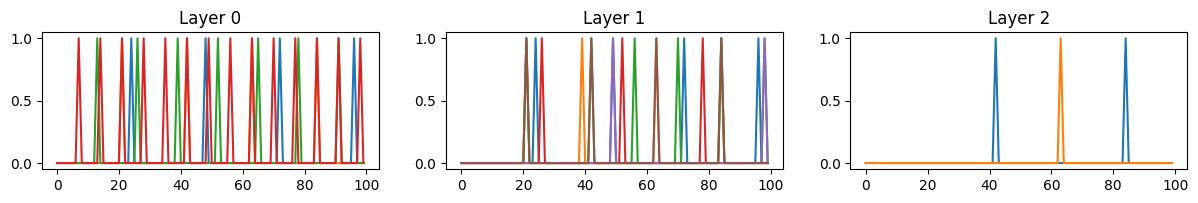

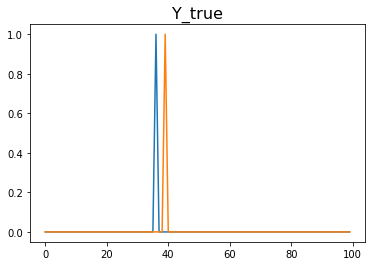

Generation :  12 / 20
Mean Train Error by best parameters found: 19.890097441096906
Mean Test Error by best parameters found: 20.30690296529374

Mean Train Error by entire population: 47.50039513123359
Mean Test Error by entire population: 47.453846199294595


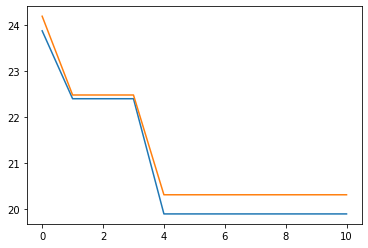

Evaluation Error: 61.18823416311342


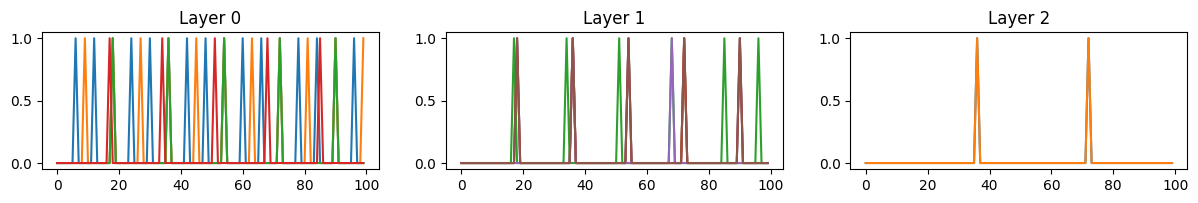

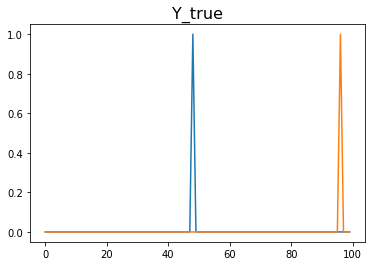

Generation :  13 / 20
Mean Train Error by best parameters found: 19.890097441096906
Mean Test Error by best parameters found: 20.30690296529374

Mean Train Error by entire population: 62.7928193016035
Mean Test Error by entire population: 61.91285349925956


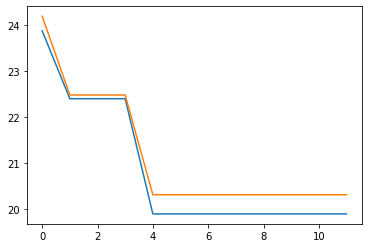

Evaluation Error: 6.708203932499369


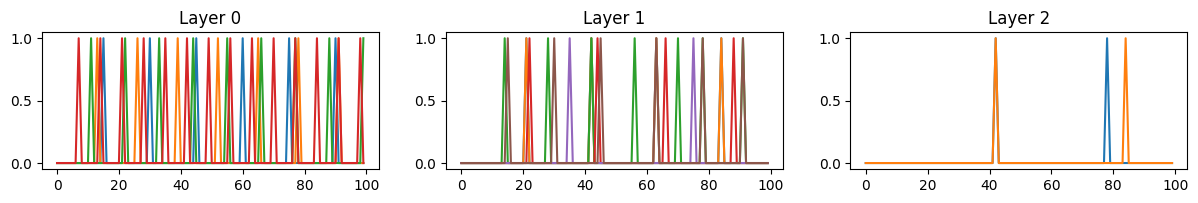

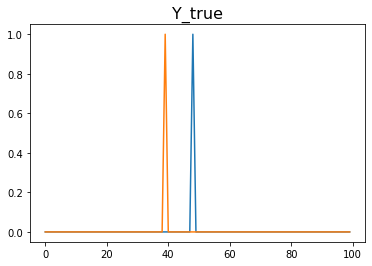

Generation :  14 / 20
Mean Train Error by best parameters found: 19.890097441096906
Mean Test Error by best parameters found: 20.30690296529374

Mean Train Error by entire population: 33.81519095327134
Mean Test Error by entire population: 33.25200348588446


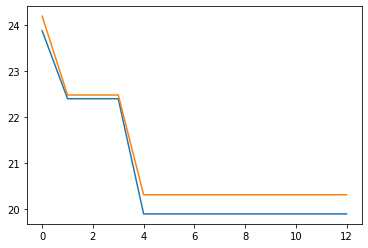

Evaluation Error: 40.024992192379


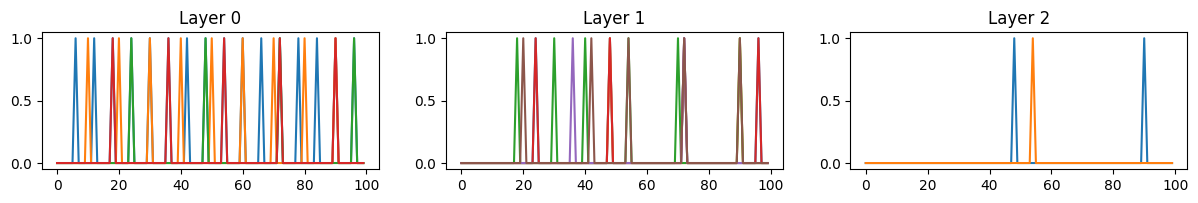

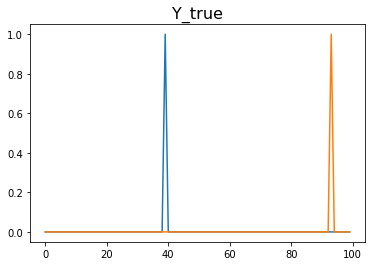

Generation :  15 / 20
Mean Train Error by best parameters found: 19.52082177500172
Mean Test Error by best parameters found: 19.812165363353436

Mean Train Error by entire population: 29.273424924646513
Mean Test Error by entire population: 29.159524548023814


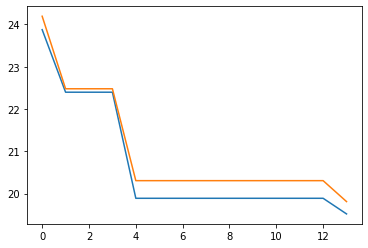

Evaluation Error: 33.54101966249684


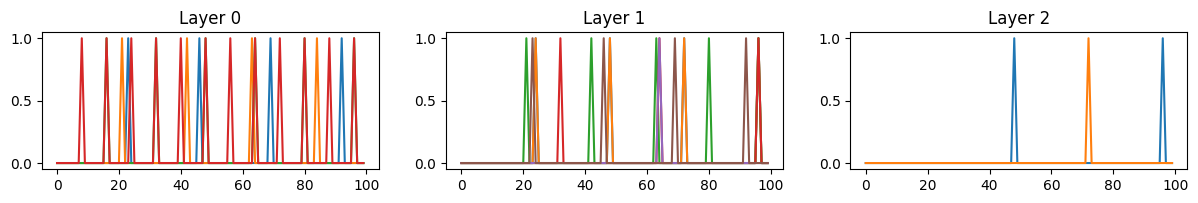

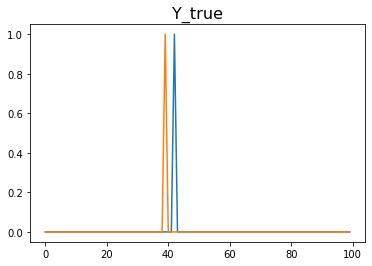

Generation :  16 / 20
Mean Train Error by best parameters found: 19.05351854740447
Mean Test Error by best parameters found: 19.410161097187807

Mean Train Error by entire population: 56.13370988942378
Mean Test Error by entire population: 55.79016081107092


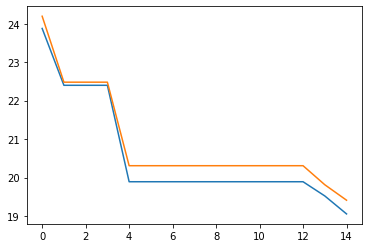

Evaluation Error: 23.0


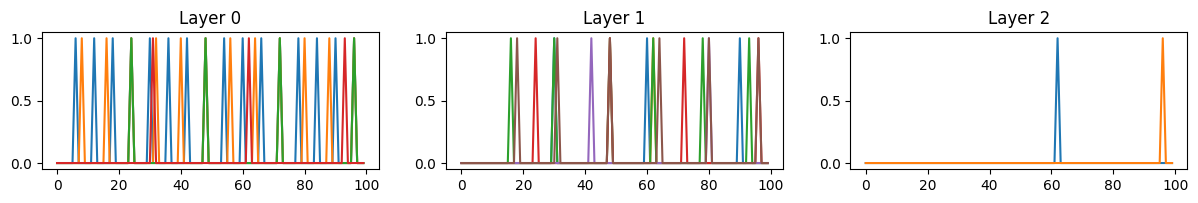

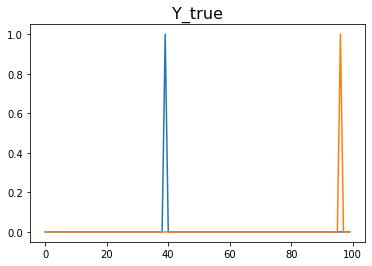

Generation :  17 / 20
Mean Train Error by best parameters found: 19.05351854740447
Mean Test Error by best parameters found: 19.410161097187807

Mean Train Error by entire population: 39.453419244648195
Mean Test Error by entire population: 39.47580219691051


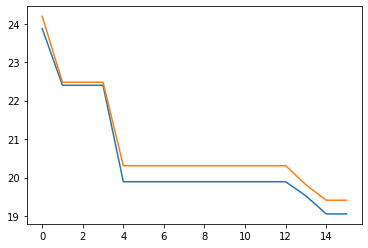

Evaluation Error: 9.055385138137417


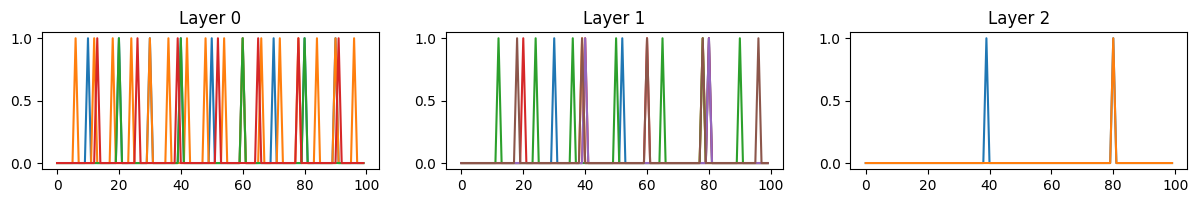

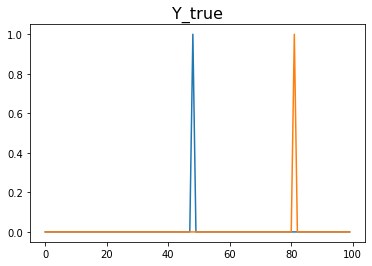

Generation :  18 / 20
Mean Train Error by best parameters found: 19.05351854740447
Mean Test Error by best parameters found: 19.410161097187807

Mean Train Error by entire population: 42.44399957418976
Mean Test Error by entire population: 42.19328575385207


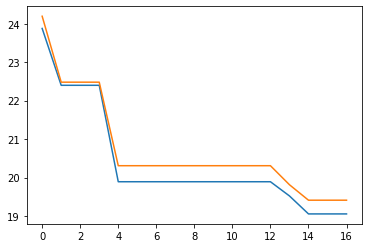

Evaluation Error: 10.816653826391969


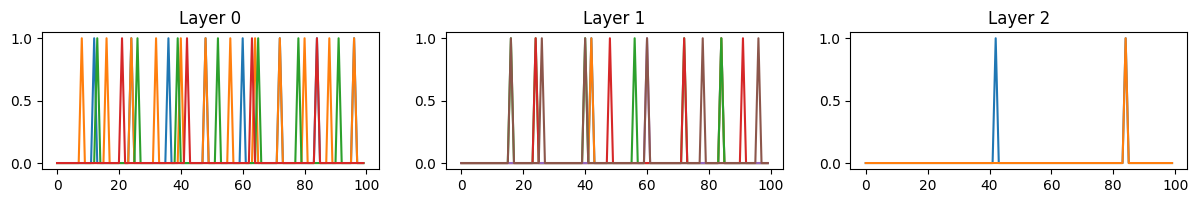

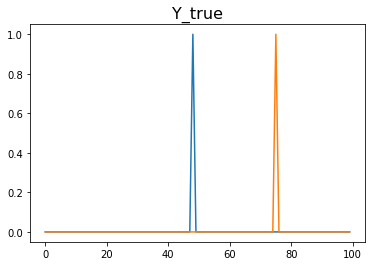

Generation :  19 / 20
Mean Train Error by best parameters found: 19.05351854740447
Mean Test Error by best parameters found: 19.410161097187807

Mean Train Error by entire population: 52.24273022451747
Mean Test Error by entire population: 51.69205710646378


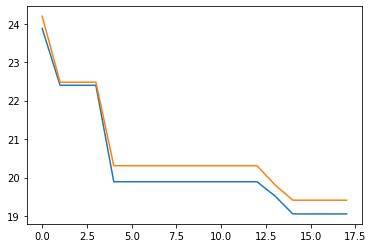

Evaluation Error: 26.1725046566048


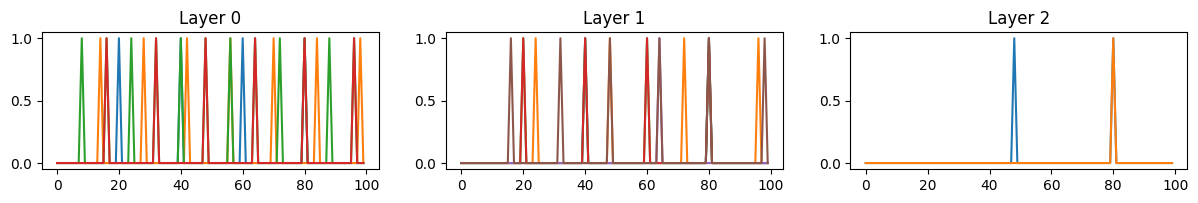

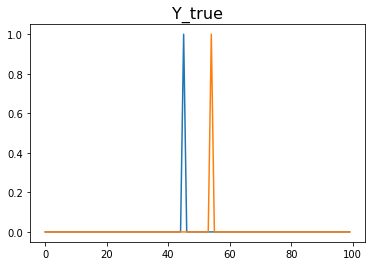

Generation :  20 / 20
Mean Train Error by best parameters found: 19.05351854740447
Mean Test Error by best parameters found: 19.410161097187807

Mean Train Error by entire population: 56.08992778857847
Mean Test Error by entire population: 55.83474726246543


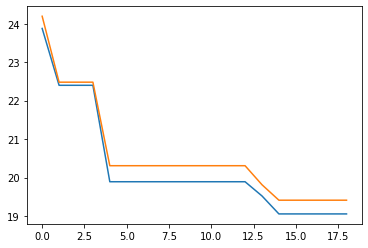

Evaluation Error: 4.0


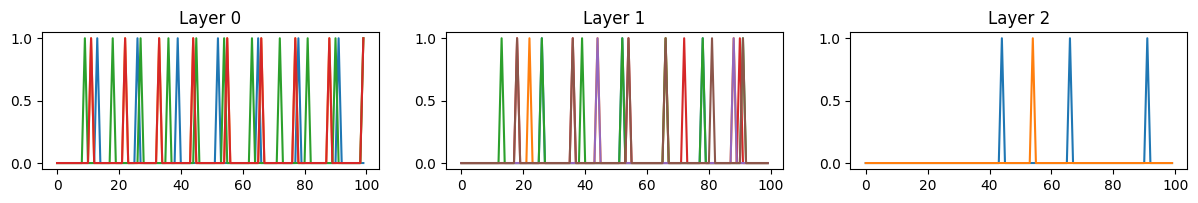

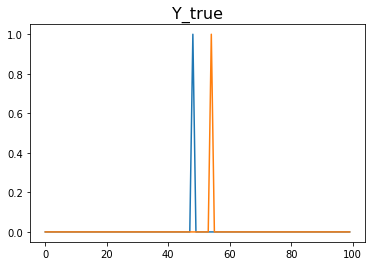

In [14]:
import multiprocessing as mp
output = mp.Queue()

#Genetic algorithm parameters
sol_per_pop = 50
num_parents_mating = 6
num_generations = 20
mutation_percent = 20
ga = GA()

#Neuron parameters
input_dim=4
neurons_per_layer=[6,2]
threshold=0.1
Cm=5

#initial population :       
#population_vectors = np.random.uniform(0, 1.5,size=(sol_per_pop, 36)) #4*6 + 6*2 = 36 

best_train_error, best_test_error = [], []
pop_train_error, pop_test_error = [], []

for generation in range(num_generations):

    #Calculate fitness for each population_vector in population    
    #send population vector for each process with id at -1 position

    temp_population_vectors = np.hstack((population_vectors, np.arange(sol_per_pop).reshape(sol_per_pop,1)))
    
    processes=[]
    for syn in temp_population_vectors:
        p = mp.Process(target = mp_fitness, args=(syn, output))
        processes.append(p)
    for p in processes:
        p.start()
    for p in processes:
        p.join()
    results = [output.get() for p in processes]
    results = np.asarray(results)
    results = results[np.argsort(results[:,0])]     #Arrange according to id 
    results = results[:, 1:]                        #remove ids from first column

    fitness_train, fitness_test = [], []
    for r in results:
        fitness_train.append(r[0])
        fitness_test.append(r[1])

    #Select best parents 
    parents = ga.select_mating_pool(population=population_vectors, fitness=fitness_train.copy(), mode='min', num_parents=num_parents_mating)
    #print(parents.shape[0],'New parents generated...')

    #Crossover parents
    offsprings = ga.crossover(parents=parents, num_offsprings=sol_per_pop-num_parents_mating)
    #print(offsprings.shape[0],'New offsprings produced...')
    
    #Mutate offsprings
    mutated_offsprings = ga.mutate(offsprings, mutation_percent=mutation_percent)
    #print(mutated_offsprings.shape[0],'offsprings mutated')
    
    #Create new population
    population_vectors[:parents.shape[0],:] = parents
    population_vectors[parents.shape[0]:,:] = mutated_offsprings
    #print('New population created')
    
    print('============================================================================')
    print("Generation : ", generation+1,'/',num_generations)
    print('============================================================================')    
    if generation != 0:                                             #Ignore first generation since parents are not sorted
        best_train_error.append(fitness_train[0])                   #Mean error by best parameters
        best_test_error.append(fitness_test[0])                     #mean error by best parameters
        print('Mean Train Error by best parameters found:', best_train_error[-1])
        print('Mean Test Error by best parameters found:', best_test_error[-1])
        print()
        plt.plot(best_train_error)
        plt.plot(best_test_error)
        plt.show()        
        #Update the result of this generation in report files
        f = open('/content/drive/My Drive/Final_year_project/NLOS_data/SNN_GA/train_error.pkl','wb')
        pickle.dump(best_train_error, f)
        f.close()
        f = open('/content/drive/My Drive/Final_year_project/NLOS_data/SNN_GA/test_error.pkl','wb')
        pickle.dump(best_test_error, f)
        f.close()        
    f = open('/content/drive/My Drive/Final_year_project/NLOS_data/SNN_GA/best_paramater_found.pkl','wb')
    pickle.dump(parents[0], f)
    f.close()
    
    pop_train_error.append(np.mean(fitness_train))              #Mean error by whole population
    pop_test_error.append(np.mean(fitness_test))                #mean error by whole population
    print('Mean Train Error by entire population:', pop_train_error[-1])
    print('Mean Test Error by entire population:', pop_test_error[-1])
    print()
    print('Random evaluation by best parameter found so far:')
    random_evaluate(vector=parents[0], input_dim=input_dim, neurons_per_layer=neurons_per_layer, threshold=threshold, Cm=Cm)